In [1]:
!unzip /content/dataset_pytorch_project.zip -d /content/

Archive:  /content/dataset_pytorch_project.zip
   creating: /content/dataset_pytorch/Breast Cancer Dataset/
   creating: /content/dataset_pytorch/Breast Cancer Dataset/0/
 extracting: /content/dataset_pytorch/Breast Cancer Dataset/0/8863_idx5_x1001_y1001_class0.png  
 extracting: /content/dataset_pytorch/Breast Cancer Dataset/0/8863_idx5_x1001_y1051_class0.png  
 extracting: /content/dataset_pytorch/Breast Cancer Dataset/0/8863_idx5_x1001_y1101_class0.png  
 extracting: /content/dataset_pytorch/Breast Cancer Dataset/0/8863_idx5_x1001_y1151_class0.png  
 extracting: /content/dataset_pytorch/Breast Cancer Dataset/0/8863_idx5_x1001_y1201_class0.png  
 extracting: /content/dataset_pytorch/Breast Cancer Dataset/0/8863_idx5_x1001_y1251_class0.png  
 extracting: /content/dataset_pytorch/Breast Cancer Dataset/0/8863_idx5_x1001_y1301_class0.png  
 extracting: /content/dataset_pytorch/Breast Cancer Dataset/0/8863_idx5_x1001_y1351_class0.png  
 extracting: /content/dataset_pytorch/Breast Cancer D

In [2]:
import torch
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score,recall_score,precision_score,classification_report
import seaborn as sns
from torch.utils.data import random_split
from tqdm import tqdm


# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define data transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
dataset = ImageFolder('/content/dataset_pytorch/Breast Cancer Dataset/', transform=transform)

# Define the sizes for training, validation, and test sets
num_train = int(0.7 * len(dataset))
num_val = int(0.1 * len(dataset))
num_test = len(dataset) - num_train - num_val

# Split the dataset
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [num_train, num_val, num_test])

# Create data loaders
trainloader = DataLoader(train_dataset, batch_size=70, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=70, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=70, shuffle=False)


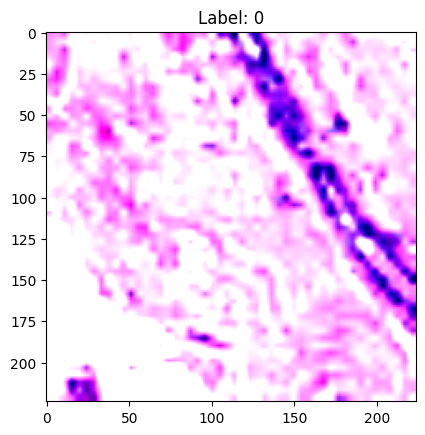

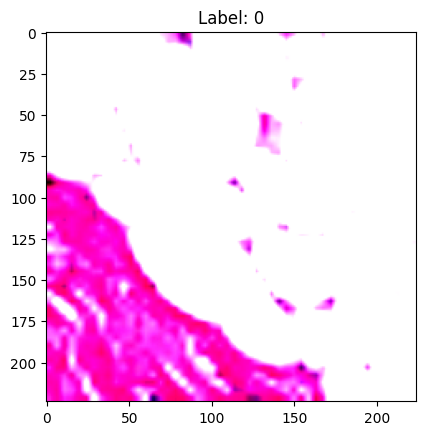

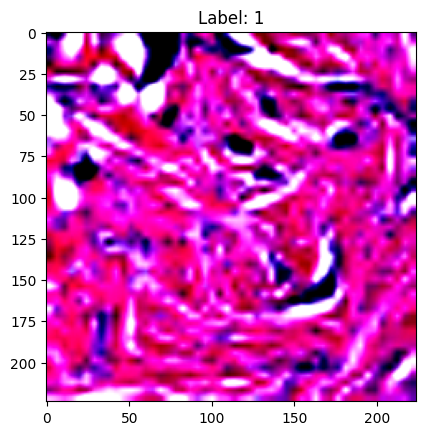

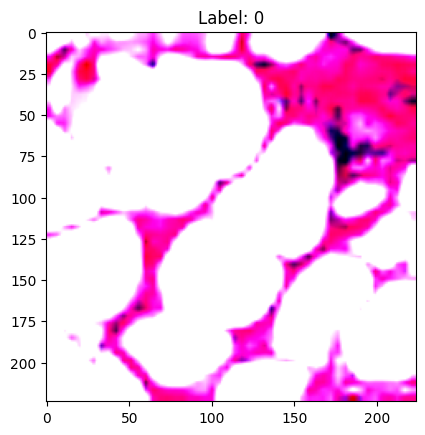

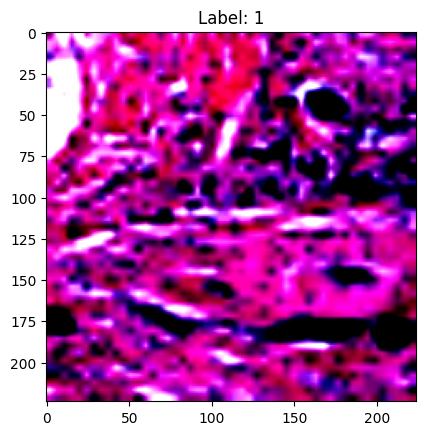

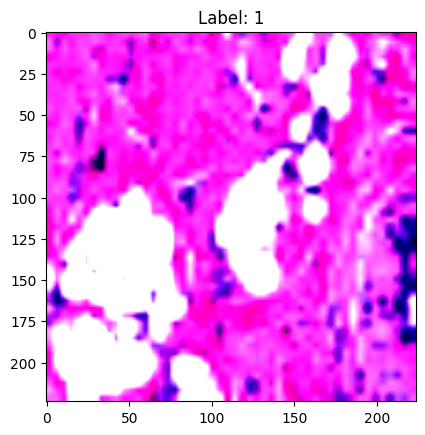

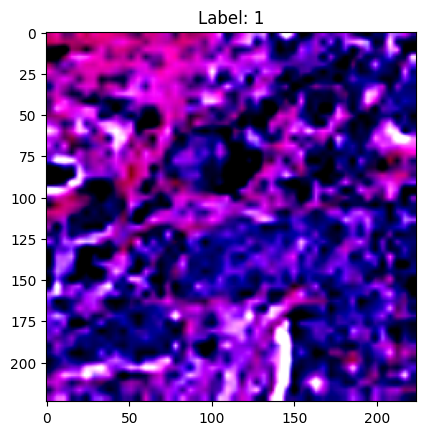

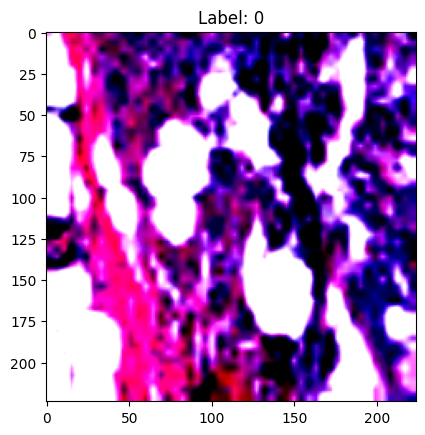

In [3]:
# Get the image and label from the DataLoader
img, label = next(iter(trainloader))

# Move the image to the CPU or GPU
img = img.to(device)

# Plot the images
for j in range(10):
    plt.imshow(img[j].cpu().numpy().transpose((1, 2, 0)))

    # Display the label of the image
    plt.title("Label: {}".format(label[j].item()))
    plt.show()


In [4]:
len(trainloader), len(train_dataset)


(23, 1596)

In [5]:
len(valloader), len(val_dataset), 1596/23

(4, 228, 69.3913043478261)

In [11]:
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False


# Replace the last fully connected layer with a single output
model.fc = nn.Linear(model.fc.in_features, 1)


# Move the model to the GPU if available -
model = model.to(device) if torch.cuda.is_available() else model


# Define a loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)


# Lists for loss and accuracy to plot later
train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []

# Train the model
for epoch in tqdm(range(20)):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # move inputs and labels to the GPU if available
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())  # Binary cross-entropy loss
        loss.backward()
        optimizer.step()

        # calculate training accuracy
        predicted = (torch.sigmoid(outputs.squeeze()) > 0.5).int()
        total += labels.size(0)
        # print(predicted.shape)
        correct += (predicted == labels).sum().item()


        # print & accumulate training statistics (loss & accuracy) every 100 iterations
        running_loss += loss.item()

    train_losses.append(running_loss / len(trainloader))
    train_accuracy.append(100 * correct / len(train_dataset))
    print('[%d, %5d] loss: %.3f' %
          (epoch + 1, i + 1, running_loss / 100))

    # Validation at the end of the epoch
    # set mode to eval mode & tell torch no gradients are required.
    model.eval()

    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            val_running_loss += loss.item()

            predicted = (torch.sigmoid(outputs.squeeze()) > 0.5).int()
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_losses.append(val_running_loss / len(valloader))
    val_accuracy.append(100 * val_correct / val_total)
    print('Epoch %d: Training Loss: %.3f | Training Accuracy: %.3f %%' %
          (epoch + 1, running_loss/len(trainloader), 100 * correct / len(train_dataset)))

    print('Epoch %d: Validation Loss: %.3f | Validation Accuracy: %.3f %%' %
          (epoch + 1, val_running_loss / len(valloader), 100 * val_correct / val_total))


    # set the model back to train mode
    model.train()

print('Finished Training')



  0%|          | 0/20 [00:00<?, ?it/s]

[1,    23] loss: 0.153


  5%|▌         | 1/20 [00:07<02:27,  7.76s/it]

Epoch 1: Training Loss: 0.665 | Training Accuracy: 59.398 %
Epoch 1: Validation Loss: 0.639 | Validation Accuracy: 62.281 %
[2,    23] loss: 0.145


 10%|█         | 2/20 [00:13<02:02,  6.81s/it]

Epoch 2: Training Loss: 0.628 | Training Accuracy: 65.414 %
Epoch 2: Validation Loss: 0.609 | Validation Accuracy: 67.105 %
[3,    23] loss: 0.139


 15%|█▌        | 3/20 [00:19<01:47,  6.31s/it]

Epoch 3: Training Loss: 0.602 | Training Accuracy: 68.484 %
Epoch 3: Validation Loss: 0.584 | Validation Accuracy: 70.614 %
[4,    23] loss: 0.133


 20%|██        | 4/20 [00:25<01:38,  6.19s/it]

Epoch 4: Training Loss: 0.580 | Training Accuracy: 71.429 %
Epoch 4: Validation Loss: 0.560 | Validation Accuracy: 73.246 %
[5,    23] loss: 0.129


 25%|██▌       | 5/20 [00:31<01:30,  6.03s/it]

Epoch 5: Training Loss: 0.559 | Training Accuracy: 75.564 %
Epoch 5: Validation Loss: 0.540 | Validation Accuracy: 73.246 %
[6,    23] loss: 0.125


 30%|███       | 6/20 [00:37<01:25,  6.09s/it]

Epoch 6: Training Loss: 0.544 | Training Accuracy: 76.566 %
Epoch 6: Validation Loss: 0.523 | Validation Accuracy: 77.632 %
[7,    23] loss: 0.121


 35%|███▌      | 7/20 [00:43<01:17,  5.95s/it]

Epoch 7: Training Loss: 0.526 | Training Accuracy: 79.323 %
Epoch 7: Validation Loss: 0.510 | Validation Accuracy: 78.509 %
[8,    23] loss: 0.119


 40%|████      | 8/20 [00:49<01:11,  6.00s/it]

Epoch 8: Training Loss: 0.515 | Training Accuracy: 80.388 %
Epoch 8: Validation Loss: 0.497 | Validation Accuracy: 81.579 %
[9,    23] loss: 0.115


 45%|████▌     | 9/20 [00:55<01:05,  5.91s/it]

Epoch 9: Training Loss: 0.502 | Training Accuracy: 80.827 %
Epoch 9: Validation Loss: 0.485 | Validation Accuracy: 82.456 %
[10,    23] loss: 0.114


 50%|█████     | 10/20 [01:01<01:00,  6.09s/it]

Epoch 10: Training Loss: 0.494 | Training Accuracy: 80.890 %
Epoch 10: Validation Loss: 0.474 | Validation Accuracy: 83.333 %
[11,    23] loss: 0.111


 55%|█████▌    | 11/20 [01:07<00:53,  5.98s/it]

Epoch 11: Training Loss: 0.484 | Training Accuracy: 82.018 %
Epoch 11: Validation Loss: 0.467 | Validation Accuracy: 82.895 %
[12,    23] loss: 0.109


 60%|██████    | 12/20 [01:13<00:47,  5.97s/it]

Epoch 12: Training Loss: 0.474 | Training Accuracy: 82.143 %
Epoch 12: Validation Loss: 0.455 | Validation Accuracy: 84.211 %
[13,    23] loss: 0.108


 65%|██████▌   | 13/20 [01:19<00:41,  5.93s/it]

Epoch 13: Training Loss: 0.469 | Training Accuracy: 81.203 %
Epoch 13: Validation Loss: 0.448 | Validation Accuracy: 84.211 %
[14,    23] loss: 0.106


 70%|███████   | 14/20 [01:25<00:36,  6.11s/it]

Epoch 14: Training Loss: 0.462 | Training Accuracy: 82.957 %
Epoch 14: Validation Loss: 0.440 | Validation Accuracy: 85.965 %
[15,    23] loss: 0.105


 75%|███████▌  | 15/20 [01:31<00:30,  6.02s/it]

Epoch 15: Training Loss: 0.456 | Training Accuracy: 82.895 %
Epoch 15: Validation Loss: 0.433 | Validation Accuracy: 86.842 %
[16,    23] loss: 0.103


 80%|████████  | 16/20 [01:37<00:24,  6.05s/it]

Epoch 16: Training Loss: 0.448 | Training Accuracy: 83.584 %
Epoch 16: Validation Loss: 0.428 | Validation Accuracy: 87.281 %
[17,    23] loss: 0.102


 85%|████████▌ | 17/20 [01:43<00:18,  6.01s/it]

Epoch 17: Training Loss: 0.444 | Training Accuracy: 84.148 %
Epoch 17: Validation Loss: 0.423 | Validation Accuracy: 86.842 %
[18,    23] loss: 0.101


 90%|█████████ | 18/20 [01:49<00:11,  5.99s/it]

Epoch 18: Training Loss: 0.439 | Training Accuracy: 83.584 %
Epoch 18: Validation Loss: 0.417 | Validation Accuracy: 87.281 %
[19,    23] loss: 0.099


 95%|█████████▌| 19/20 [01:55<00:06,  6.06s/it]

Epoch 19: Training Loss: 0.433 | Training Accuracy: 84.461 %
Epoch 19: Validation Loss: 0.414 | Validation Accuracy: 88.158 %
[20,    23] loss: 0.099


100%|██████████| 20/20 [02:01<00:00,  6.08s/it]

Epoch 20: Training Loss: 0.430 | Training Accuracy: 84.837 %
Epoch 20: Validation Loss: 0.408 | Validation Accuracy: 87.719 %
Finished Training


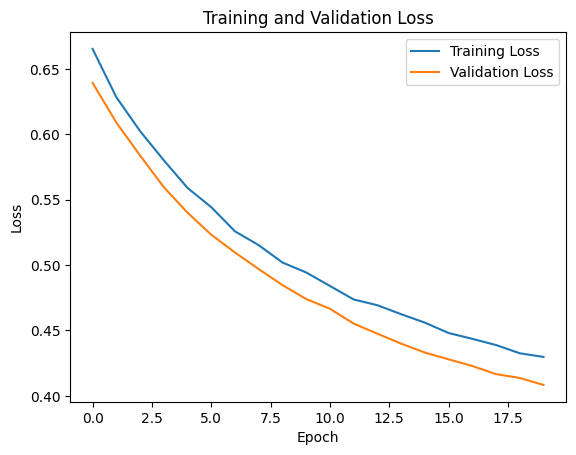

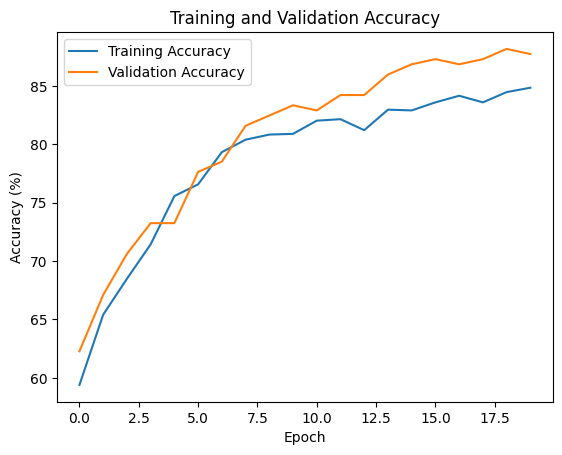

In [12]:
# Plot training loss over time
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy over time
plt.figure()
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()


In [17]:
len(testloader), len(test_dataset)

(7, 456)

In [26]:
# Test the model on test data and get confusion matrix
y_true = []
y_pred = []
image_list = []
true_labels = []
preds = []
total_batches = 0
test_loss = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = (torch.sigmoid(outputs.squeeze()) > 0.5).int()
        y_true += labels.cpu().numpy().tolist()
        y_pred += predicted.cpu().numpy().tolist()
        preds.extend(predicted)
        image_list.extend(images.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        # loss = criterion(outputs.squeeze(), labels.float())
        # test_loss += loss.item()
        total_batches += 1

# avg_test_loss = test_loss / total_batches
# print("Average Test Loss:", avg_test_loss)


# Calculate accuracy
accuracy = np.mean(np.array(y_true) == np.array(y_pred))
print(f"Accuracy: {accuracy * 100:.3f}%")

num_rows = 10
num_cols = 5

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 4*num_rows), gridspec_kw={'hspace': 0.5})
num_elements = axes.shape[0] * axes.shape[1]

# Iterator for test_loader
for i in range(num_elements):
    ax = axes[i//axes.shape[1], i%axes.shape[1]]
    ax.imshow(np.clip(image_list[i].transpose(1, 2, 0), 0, 1))
    ax.set_title(f"Pred: {preds[i]}\nTrue: {true_labels[i]}")
    ax.axis('off')

plt.tight_layout()
plt.show()


Accuracy: 83.553%


<ipython-input-26-e9f1c584202a>:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


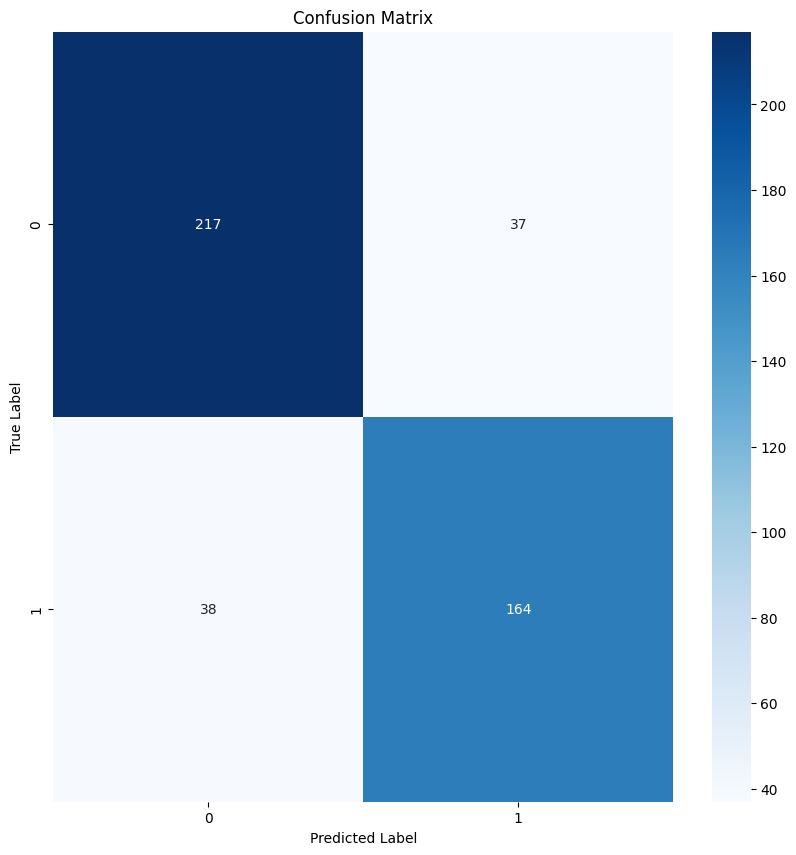

In [20]:
# Find and plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# -----------------------------------------------------------------------------


In [21]:
# # Print F1 score,recall and precision
# f1 = f1_score(y_true, y_pred, average='weighted')
# recall = recall_score(y_true, y_pred, average='weighted')
# precision = precision_score(y_true, y_pred, average='weighted')

# print('F1 Score: ', f1)
# print('Recall:', recall)
# print('Precision:', precision)

In [22]:
# Assuming y_true and y_pred are the true and predicted labels
report = classification_report(y_true, y_pred)
print(report)


              precision    recall  f1-score   support

           0       0.85      0.85      0.85       254
           1       0.82      0.81      0.81       202

    accuracy                           0.84       456
   macro avg       0.83      0.83      0.83       456
weighted avg       0.84      0.84      0.84       456

